In [1]:
import numpy as np
import basix
import matplotlib.pyplot as plt
from basix import CellType, ElementFamily, LagrangeVariant, LatticeType
import jax_pn
from jax_pn.ADPN import GlobalSettings
import jax
import jax.numpy as jnp
%load_ext autoreload
%autoreload 2
jax.config.update("jax_enable_x64", True)

In [2]:
factor = 3.0
m_cm = 1/100
water = (np.array([15.2090, 24.4140]) * m_cm,
         np.array([[[5.5069 , 0.0   ],
                  [6.6227, 11.4080]],
                  [[3.4757 /factor,  0.0    /factor],
                   [3.7043 /factor,  6.7420 /factor]]]) * m_cm)

iron = (np.array([30.3110, 26.8760]) * m_cm,
        np.array([[[18.250, 0.0   ],
                   [6.4496, 21.3570]],
                  [[13.0890  /factor ,  0.0  /factor],
                   [-0.010523/factor ,7.0373 /factor]]]) * m_cm
)

void = (np.array([0.0, 0.0]),
        np.array([[[0.0, 0.0],
                   [0.0, 0.0]],
                  [[0.0, 0.0],    
                   [0.0, 0.0]]]))

source = np.array([0.097702, 0.45451])
zero_source = np.array([0.0, 0.0])

In [3]:

lagrange    = basix.create_element(ElementFamily.P, CellType.interval, degree= 5, lagrange_variant= LagrangeVariant.gll_warped)
N_max = 5

regions = [
    (20, *water, zero_source), 
    (10, *water, source ),
    (50, *water, zero_source),
    (20, *iron,  zero_source),
    (10, *void, zero_source),
    (10, *water, zero_source),
    (10, *void,  zero_source)
]
elements_per_cm = 1.0



In [4]:
adpn_prob = jax_pn.ADPN.ADPN_Problem.from_regions_per_cm(regions, elements_per_cm, N_max, lagrange, L_scat=1)
solution  = adpn_prob.Solve_Multigroup_System('vacuum',2) 


Solving system with shape: (7824, 7824) and 7824 equations.


In [12]:
from jax_pn.ADPN import vmap_local_residual_PN_eg, residual_bc_marshak_eg_jit
def residualPN_eg(global_settings : GlobalSettings, matrix_settings, parameters_eg, solution):
      # shape: (n_elems, n_moments, n_local_dofs)
    moments = jnp.arange(global_settings.n_moments)
    elems   = jnp.arange(global_settings.n_elements)
    # Compute global indices for all (elem, moment, dof)
    n_moments     = global_settings.n_moments    
    n_global_dofs = global_settings.n_global_dofs
    n_groups      = global_settings.n_energy_groups

    eg = jnp.arange(n_groups)

    local_residuals = vmap_local_residual_PN_eg(
        eg,
        moments,
        elems,
        global_settings,
        matrix_settings,
        parameters_eg,
        solution
    )    
    global_residual = jnp.zeros_like(solution)

    for g in range(n_groups):
        
        offset_g = global_settings.n_dofs_per_eg * g
        for k in range(n_moments):            
            offset_k = offset_g + global_settings.n_global_dofs * k

            global_dof_indices = matrix_settings["elem_dof_matrix"] + offset_k
            global_residual    = global_residual.at[global_dof_indices].add(local_residuals[:, k, g, :])
        
        bcs = residual_bc_marshak_eg_jit(
            g,
            global_settings,
            matrix_settings,            
            solution,            
        )    
        global_residual = global_residual.at[offset_g + global_settings.n_global_dofs * n_moments : offset_g + global_settings.n_global_dofs * n_moments + n_moments].add(bcs)

    return global_residual

parameters_eg = {
    'sigma_t_i'       : adpn_prob.jax_sigma_t,
    'sigma_s_k_i_gg'  : adpn_prob.jax_sigma_s,
    'h_i'             : adpn_prob.jax_h_i,
    'q_i_k_j'         : adpn_prob.jax_q_i_k_j
}

total_residuals = residualPN_eg(adpn_prob.global_settings, adpn_prob.matrix_settings, parameters_eg, solution)
jac_A    = jax.jit(jax.jacfwd(residualPN_eg, argnums = (3,)), static_argnums = 0)

In [6]:

drdx = jac_A(adpn_prob.global_settings, adpn_prob.matrix_settings, parameters_eg, solution)[0]

In [7]:
anormal = adpn_prob.assemble_multigroup_system('vacuum', 2)[0]

In [8]:
first_eg = 0#adpn_prob.global_settings.n_dofs_per_eg
print(np.max(np.abs(anormal.todense()[first_eg:, first_eg:] - drdx[first_eg:,  first_eg: ])))

0.0


/tmp/ipykernel_132820/941295518.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1)


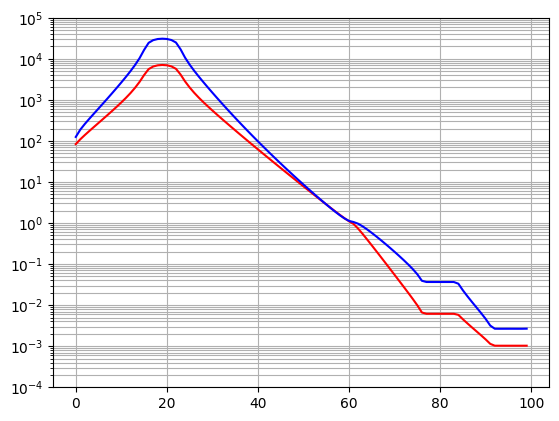

In [11]:

plt.semilogy(1e4 *(adpn_prob.interpolate_solution(np.linspace(0,130, 100), energy_group = 0, k = 0)),'r')
plt.semilogy(1e4 *(adpn_prob.interpolate_solution(np.linspace(0,130, 100), energy_group = 1, k = 0)),'b')


plt.ylim(0,1)
plt.ylim(1e-4,1e5)
plt.grid(which='both')